In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plt.rcParams['figure.figsize'] = [20, 7]

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [2]:
store_sales = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

In [3]:
# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

In [4]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Text(0.5, 1.0, 'SEAFOOD Sales at Store 12')

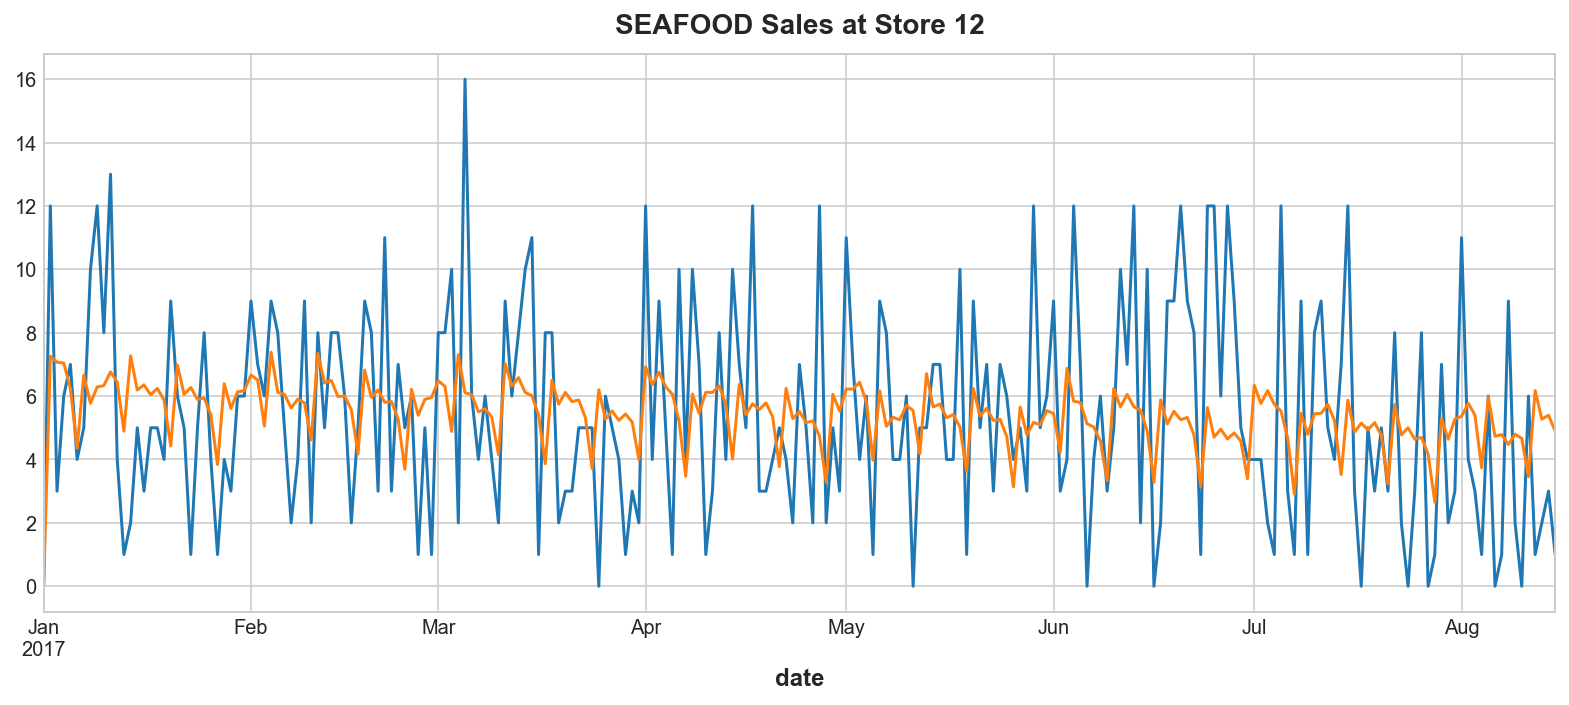

In [5]:
STORE_NBR = '12'  # 1 - 54
FAMILY = 'SEAFOOD'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot()
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}')

Text(0.5, 1.0, 'Average of Deseasoned Data')

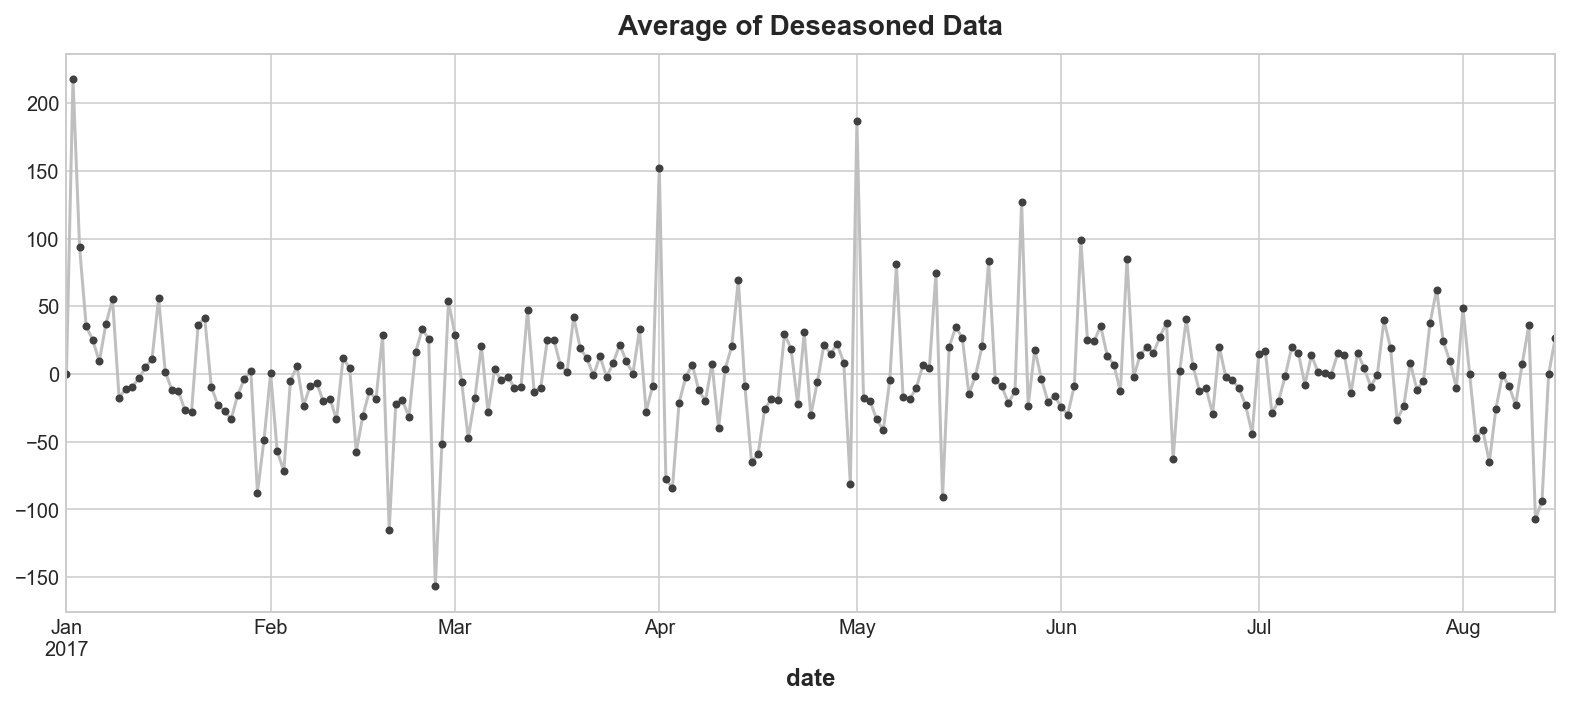

In [6]:
y_deseason = y - y_pred

average_sales_deseason = (
    y_deseason.stack(['store_nbr', 'family']).loc[:, ['sales']]
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

ax = average_sales_deseason.plot(**plot_params)
ax.set_title('Average of Deseasoned Data')

<ipython-input-7-6f79f91f742d>:2: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax1 = plot_periodogram(average_sales, ax=ax1)
<ipython-input-7-6f79f91f742d>:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax2 = plot_periodogram(average_sales_deseason, ax=ax2);


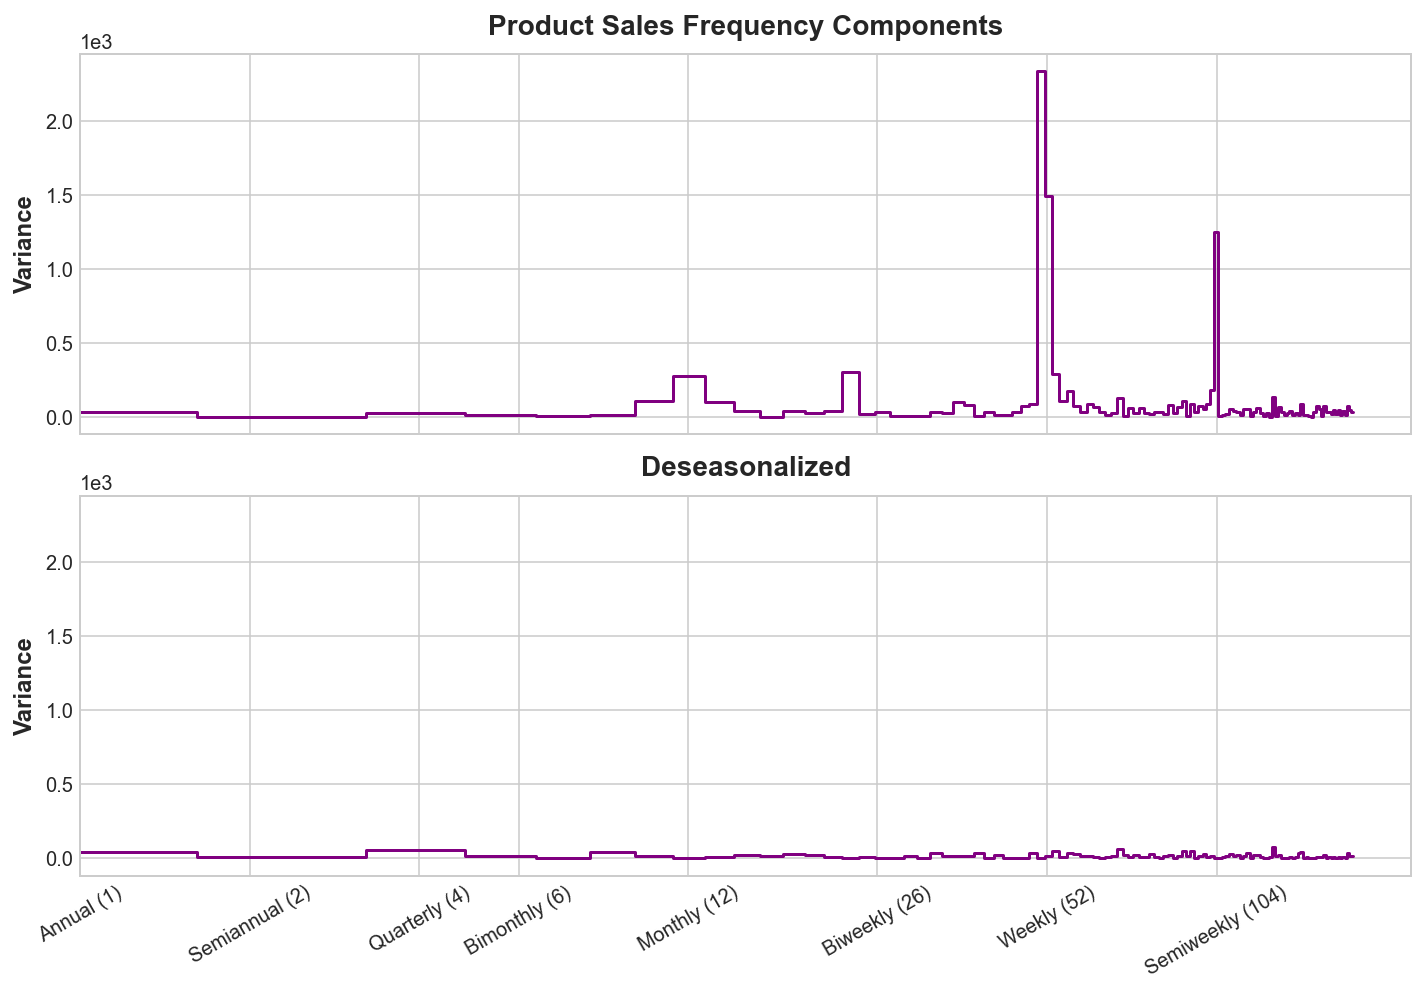

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(average_sales, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(average_sales_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [8]:
# df_test = pd.read_csv(
#     'test.csv',
#     dtype={
#         'store_nbr': 'category',
#         'family': 'category',
#         'onpromotion': 'uint32',
#     },
#     parse_dates=['date'],
#     infer_datetime_format=True,
# )
# df_test['date'] = df_test.date.dt.to_period('D')
# df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()
#
# # Create features for test set
# X_test = dp.out_of_sample(steps=16)
# X_test.index.name = 'date'
# X_test['NewYear'] = (X_test.index.dayofyear == 1)
#
#
# y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
# y_submit = y_submit.stack(['store_nbr', 'family'])
# y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
# y_submit.to_csv('submission.csv', index=False)